In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader
import pickle
from tqdm import tqdm

### import the data

In [2]:
data=pd.read_csv("merged_data_edited.csv")

/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(473824, 22)

### Extract columns needed

In [4]:
df=data[["reviewID", "reviewTime","reviewerID", "productID","overall", "title"]]

In [5]:
df.head()

,reviewID,reviewTime,reviewerID,productID,overall,title
0,0,2015-10-17,A1HP7NVNPFMA4N,0700026657,5,Anno 2070
1,1,2015-07-27,A1JGAP0185YJI6,0700026657,4,Anno 2070
2,2,2015-02-23,A1YJWEXHQBWK2B,0700026657,3,Anno 2070
3,3,2015-02-20,A2204E1TH211HT,0700026657,2,Anno 2070
4,4,2014-12-25,A2RF5B5H74JLPE,0700026657,5,Anno 2070


In [6]:
df["overall"].describe()

count    473824.000000
mean          4.226291
std           1.182626
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

Average rating is 4.22

# A Simple User based CF---Pearson correlation on ratings to compare similarities

### Preparation (Ratings table and game_matrix)

In [7]:
#Create a new dataframe called ratings grouped by product ID and calculated the average rating per each product ID
ratings = pd.DataFrame(df.groupby('productID')['overall'].mean())
ratings.head()

,overall
productID,
0700026398,3.125000
0700026657,3.692308
0700099867,3.300000
0804161380,4.816327
3828770193,4.333333


In [8]:
#Add number of ratings per each product ID
ratings['number_of_ratings'] = df.groupby('productID')['overall'].count()
ratings.head()

,overall,number_of_ratings
productID,,
0700026398,3.125000,8
0700026657,3.692308,13
0700099867,3.300000,30
0804161380,4.816327,49
3828770193,4.333333,6


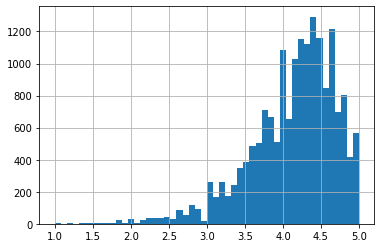

In [9]:
#Now make a plot to visualize average ratings
%matplotlib inline 
#makes your plot outputs appear and be stored within the notebook
ratings['overall'].hist(bins=50)

We can see that most movie ratings are between 3.5 and 5.

[0, 160, 0, 12000]

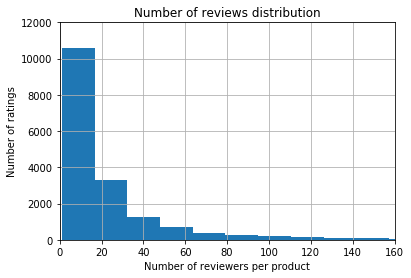

In [26]:
#Visualize number of ratings
ratings['number_of_ratings'].hist(bins=50)
plt.xlabel('Number of reviewers per product')
plt.ylabel('Number of ratings')
plt.title("Number of reviews distribution")
plt.axis([0, 160, 0, 12000])

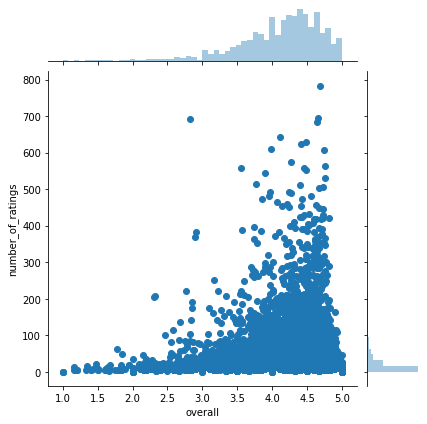

In [14]:
#Now let us check the relationship between the ratings of a product and the number of ratings
sns.jointplot(x='overall', y='number_of_ratings', data=ratings)

As number of ratings increases, we see the overall ratings tend to increase as well---small positive relationship observed.

In [5]:
#Build a matrix between reviewerID and productID
game_matrix = df.pivot_table(index='reviewerID', columns='productID', values='overall')
game_matrix.head()

productID,0700026398,0700026657,0700099867,0804161380,3828770193,6050036071,7293000936,7544256944,8176503290,8565000168,...,B01HD1B76O,B01HD2TECW,B01HDJFJKG,B01HDJFJLK,B01HDJFJOM,B01HFRICLE,B01HGPUTCA,B01HH6JEOC,B01HIZF7XE,B01HIZGKOE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0059486XI1Z0P98KP35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0220159ZRNBTRKLG08H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0266076X6KPZ6CCHGVS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0277912HT4JSJKVSL3E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02836981FYG9912C66F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#Find top 10 productIDs with most number of ratings
ratings.sort_values('number_of_ratings', ascending=False)

,overall,number_of_ratings
productID,,
B00JK00S0S,4.690932,783
B003ZSP0WW,4.651297,694
B00178630A,2.829480,692
B00GODZYNA,4.644737,684
B000P46NMA,4.110420,643
...,...,...
B0011UEPB8,4.000000,1
B0013953N6,4.000000,1
B000WZ7OD4,1.000000,1


### Let us do a recommendation system test on one product

In [57]:
#Let us check the product with the largest number of ratings
B00178630A_user_rating=game_matrix['B00178630A']
B00178630A_user_rating.head()

reviewerID
A0059486XI1Z0P98KP35   NaN
A0220159ZRNBTRKLG08H   NaN
A0266076X6KPZ6CCHGVS   NaN
A0277912HT4JSJKVSL3E   NaN
A02836981FYG9912C66F   NaN
Name: B00178630A, dtype: float64

In [58]:
#Let us compare correlation between those two products
similar_to_B00178630A=game_matrix.corrwith(B00178630A_user_rating)

/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [59]:
similar_to_B00178630A.sort_values(ascending=False)

productID
B00KWF366S    1.0
B000V9C9FO    1.0
B000HKKM2Y    1.0
B000IN0BSU    1.0
B0064TYRAU    1.0
             ... 
B01HFRICLE    NaN
B01HGPUTCA    NaN
B01HH6JEOC    NaN
B01HIZF7XE    NaN
B01HIZGKOE    NaN
Length: 17408, dtype: float64

We can see some strong correlations from above.

In [33]:
similar_to_B00178630A.describe()

count    918.000000
mean       0.249138
std        0.752845
min       -1.000000
25%       -0.413403
50%        0.500000
75%        1.000000
max        1.000000
dtype: float64

25% of other products are perfectly correlated with B00178630A. Probably because this game got a lot of ratings.

In [34]:
#Make similar_to_B00178630A looks better
corr_B00178630A = pd.DataFrame(similar_to_B00178630A, columns=['Correlation'])
corr_B00178630A.dropna(inplace=True)
corr_B00178630A.head()

,Correlation
productID,
0700099867,0.500000
B00000F1GM,-1.000000
B00001IVRD,0.353553
B00001LCDM,1.000000
B00001OWYW,-0.693375


In [35]:
#Add number of ratings to this correlation based dataframe
corr_B00178630A = corr_B00178630A.join(ratings['number_of_ratings'])
corr_B00178630A.head()

,Correlation,number_of_ratings
productID,,
0700099867,0.500000,30
B00000F1GM,-1.000000,172
B00001IVRD,0.353553,113
B00001LCDM,1.000000,10
B00001OWYW,-0.693375,75


In [48]:
#Limit products and only keep products with number of ratings >50 and view the top 10
corr_B00178630A[corr_B00178630A['number_of_ratings'] > 50].sort_values(by='Correlation', ascending=False)

,Correlation,number_of_ratings
productID,,
B002Q8IHDQ,1.0,70
B00NW6T6CC,1.0,169
B00LLIQS6U,1.0,134
B003O6JKLC,1.0,176
B00ZPZQKIG,1.0,82
...,...,...
B000ASBKHE,-1.0,123
B001MBUGLY,-1.0,92
B001TOMR6Q,-1.0,79


### Let us now build a recommendation system function in order to generalize

# Item based

In [86]:
#Exclude the product that the user already bought
#A function to input user, and output product 
#Create a table (each row-user, ten columns with recommendations)
#clean duplicates
#Take some users out, as validation set
def item_based_CF(productID, number_of_ratings):
    user_rating=game_matrix[productID]
    similar_to=game_matrix.corrwith(user_rating)
    corr = pd.DataFrame(similar_to, columns=['Correlation'])
    corr.dropna(inplace=True)
    corr = corr.join(ratings['number_of_ratings'])
    corr_sorted=corr[corr['number_of_ratings'] > number_of_ratings].sort_values(by='Correlation', ascending=False)
    i=0
    idx=0
    result=""
    while i<10:
        if corr_sorted.index[idx]!=productID:
            result=result+corr_sorted.index[idx]+","
            i=i+1  
        idx=idx+1
    return result

# User based (Cosine Similarity)

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [7]:
with open('train_df_with_valid_recommendations.pkl', 'rb') as f:
    train = pickle.load(f)

In [6]:
with open('validation_df_with_valid_recommendations.pkl', 'rb') as f:
    validation = pickle.load(f)

In [14]:
train_pivot_table=pd.pivot_table(train,values='overall',index='reviewerID',columns='productID')

In [15]:
train_pivot_table

productID,0700026398,0700026657,0700099867,3828770193,8176503290,907843905X,B000003SQQ,B000006OVE,B000006OVG,B000006OWR,...,B01HC8QZG0,B01HD1B64C,B01HD1B76O,B01HDJFJKG,B01HDJFJLK,B01HDJFJOM,B01HFRICLE,B01HH6JEOC,B01HIZF7XE,B01HIZGKOE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0059486XI1Z0P98KP35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0220159ZRNBTRKLG08H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0266076X6KPZ6CCHGVS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0277912HT4JSJKVSL3E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02836981FYG9912C66F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZHLZ8H23QD4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZKH219IDQGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZT1ERHBSNQ8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Replacing NaN by Movie Average
train_pivot_table = train_pivot_table.fillna(train_pivot_table.mean(axis=0))

In [9]:
train_pivot_table

productID,0700026398,0700026657,0700099867,3828770193,8176503290,907843905X,B000003SQQ,B000006OVE,B000006OVG,B000006OWR,...,B01HC8QZG0,B01HD1B64C,B01HD1B76O,B01HDJFJKG,B01HDJFJLK,B01HDJFJOM,B01HFRICLE,B01HH6JEOC,B01HIZF7XE,B01HIZGKOE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0059486XI1Z0P98KP35,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
A0220159ZRNBTRKLG08H,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
A0266076X6KPZ6CCHGVS,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
A0277912HT4JSJKVSL3E,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
A02836981FYG9912C66F,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZHLZ8H23QD4,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
AZZKH219IDQGY,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5
AZZT1ERHBSNQ8,3.166667,3.714286,3.538462,4.2,3.5,3.333333,3.5,4.117647,4.5,2.6,...,3.0,1.666667,1.75,4.666667,4.571429,4.6,4.3,3.625,4.657895,3.5


In [10]:
# user similarity on replacing NAN by item(movie) avg
cosine = cosine_similarity(train_pivot_table)


In [11]:
np.fill_diagonal(cosine, 0 )

In [12]:
cosine

array([[0.        , 0.99999072, 0.99999846, ..., 0.99999843, 0.99999918,
        0.99999901],
       [0.99999072, 0.        , 0.99999066, ..., 0.99999064, 0.99999139,
        0.99999122],
       [0.99999846, 0.99999066, 0.        , ..., 0.99999838, 0.99999913,
        0.99999896],
       ...,
       [0.99999843, 0.99999064, 0.99999838, ..., 0.        , 0.9999991 ,
        0.99999942],
       [0.99999918, 0.99999139, 0.99999913, ..., 0.9999991 , 0.        ,
        0.99999968],
       [0.99999901, 0.99999122, 0.99999896, ..., 0.99999942, 0.99999968,
        0.        ]])

In [13]:
similarity_with_games =pd.DataFrame(cosine,index=train_pivot_table.index)
similarity_with_games.columns=train_pivot_table.index
similarity_with_games.head()

reviewerID,A0059486XI1Z0P98KP35,A0220159ZRNBTRKLG08H,A0266076X6KPZ6CCHGVS,A0277912HT4JSJKVSL3E,A02836981FYG9912C66F,A0331487QH9BVBTYGNCV,A03622674FSWUX0PXPAK,A0380485C177Q6QQNJIX,A0385843DE41TCVXH2I1,A0429448FT6MHSF724JB,...,AZYUNW5G2R3CL,AZYWRH9CQSB2Q,AZZ1KF8RAO1BR,AZZ2RPY63LR0B,AZZ3GFL1HTBLY,AZZHLZ8H23QD4,AZZKH219IDQGY,AZZT1ERHBSNQ8,AZZTC2OYVNE2Q,AZZTOUKVTUMVM
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0059486XI1Z0P98KP35,0.000000,0.999991,0.999998,0.999988,0.999997,0.999990,0.999989,0.999971,0.999999,0.999993,...,0.999988,0.999993,0.999967,0.999997,0.999956,0.999987,0.999995,0.999998,0.999999,0.999999
A0220159ZRNBTRKLG08H,0.999991,0.000000,0.999991,0.999980,0.999990,0.999983,0.999981,0.999963,0.999991,0.999985,...,0.999980,0.999985,0.999959,0.999990,0.999948,0.999979,0.999987,0.999991,0.999991,0.999991
A0266076X6KPZ6CCHGVS,0.999998,0.999991,0.000000,0.999988,0.999997,0.999990,0.999989,0.999971,0.999999,0.999993,...,0.999988,0.999993,0.999967,0.999997,0.999956,0.999987,0.999995,0.999998,0.999999,0.999999
A0277912HT4JSJKVSL3E,0.999988,0.999980,0.999988,0.000000,0.999987,0.999980,0.999978,0.999960,0.999988,0.999982,...,0.999978,0.999982,0.999957,0.999987,0.999946,0.999977,0.999985,0.999988,0.999989,0.999989
A02836981FYG9912C66F,0.999997,0.999990,0.999997,0.999987,0.000000,0.999989,0.999987,0.999969,0.999998,0.999992,...,0.999987,0.999993,0.999966,0.999996,0.999955,0.999986,0.999994,0.999997,0.999998,0.999998


In [14]:
def find_n_neighbours(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False)
           .iloc[:n].index, 
          index=['top{}'.format(i) for i in range(1, n+1)]), axis=1)
    return df

In [15]:
similar_user_30=find_n_neighbours(similarity_with_games,30)

In [16]:
similar_user_30

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top21,top22,top23,top24,top25,top26,top27,top28,top29,top30
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0059486XI1Z0P98KP35,A2SRWCLK11CNIC,A22W0WW0N7QE6J,AEBM90RWESSYI,A212MA0T75370H,A1ENEUNA9U2FUE,A34S5KKOKVXHUE,A2901QB8L9LH9W,A20CLGHM5GYJZR,A9SVYZ34G64C4,A11TTKJOZ1DR9G,...,A39D745DVPDFAY,A1OXBC8WDYOT4A,A15F62O3OVCG0,A165VHG8ZMGVNB,AFGDTREI8HFAC,A1X3T9VBU5GQX4,A31EJW113JXCM6,A3QA4B599DXPT5,A12A68NIAN9KHK,A3UWH6O7429Q5C
A0220159ZRNBTRKLG08H,A2OU3ARFCXGCDG,AUNCK0Z0CJ9JS,A1F24VXA0QAJCR,A3DZNSGVR5TM0F,A197ARI94JADZ8,A1PUV4XTMT14L3,A2NF4VDSPQ1S54,A88I7HFLGPWJF,A1OQ0Q77T3LH6V,A19CAM57RGQCAI,...,A3J2M2CQE3S0XR,A3O2AT99EDFZTL,A1OZFMJ2AD2R41,A103AZLY78GMZW,A33V5HGY98WUHE,AIBYKRZ81AIA1,A3FRUIXXXO8RGY,A24Y7158HENIKO,A1QE5N2H9YGRTS,A1AU3FENNQJ6RR
A0266076X6KPZ6CCHGVS,A2ZROJYT3CPM8K,A342L12WLT91P7,A1KZZFQ7XKUPIC,A3FO7DDYPHUA6N,A2W3E5Z5CW5Y5J,AARKA3TBF2LV4,A3G4UAHIATGNEK,A15F62O3OVCG0,AA9QH1REWJN6B,AG4J5ZEBRVSAM,...,A3856S2K87M05H,A12A68NIAN9KHK,AHT993I2V49NT,A1N79L0O2ZQVGE,A1FTBJ1U8ATC6Y,A1K0C3I5ATIEUX,A17FKTR7GIPD5H,A2FIDHFNEB2WGD,AIKH2Q3SW4682,A1NTOH9XJ5K3XU
A0277912HT4JSJKVSL3E,A11RPZTJA2FALM,AMP1QFBYOYJKL,A28RTDNHOOOZ15,A2ESJ07T0E2FOY,A4X2NM1CZL8TV,A17PHEJVQ0T1FB,A144ZSAXBCIGUE,AQERGSL9L1S1I,A1KS83ZTZ3MGBE,A1HHRVLNLMX16I,...,A293QQXILMOMQ7,A2X07QP252I9H1,A2SV60ZND4ZVHZ,AG3OQ1LYDYY3C,A2T16P243GD5F3,A1DJDDPJP6THC1,A2E1G1R90G50HN,A147XFM8LE1O9K,A3CQPJAY6NF55E,A2MZ86KZBEVOVI
A02836981FYG9912C66F,A3AAWCXSF99MWG,A1ASWDAEDTTY5I,A3LP8T01F8Z1V7,AUWFLB8MOUKG,A3JJLPRN3JSDXT,A18EA182TUEWBH,A18E5D7S4CJ5M5,A25X214CYKDLTA,A1SD5BFE0CYKDV,A3GT2TSW3PJCSJ,...,A1FEWNLM96082J,A1F2DTHKQAZCMX,A5CRA0O4QEWTK,A2URULTKOCNGPZ,A1R1DPRAX5LWF3,A3AGGOVLFLR34J,A1R46LMPK1XVQB,A12GRO9MONIDOG,A3JBFL1ZUYVIF3,AARKA3TBF2LV4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZHLZ8H23QD4,A2ND4ALFEZPBSJ,A2YP947JL8FZW3,A2IO3K2QC5Q05A,A37I52NNOYNMW7,A22CGPNH63WDJZ,A395B3Q26IWMNA,A1P2T6OKXQX60H,AYVUA9ODMSTT3,A2W14APMO06WFM,AUBN42SSD2N44,...,A2ZDIIKCWYQ34V,A3QVFASUI60E5Q,A3I5CWJ0NBD3VV,A3IFI14LQ1RRE8,A28BGSDHX83YJ6,A3BNVBQ01Z3IX1,A2BDWTZ9R9MDGE,A39AHD51V9QJ5X,A2YK23SR6DKPAW,A1Y5O0E666IO4G
AZZKH219IDQGY,A1AUIC59Q7DWUI,A1NTOH9XJ5K3XU,APJ9GMM4Q6SSC,A3EFW5148VIX67,A24Y7158HENIKO,A2ZE59FWPRBGA7,A3EBXFGN31IYAQ,A24W7DSXVMY5JF,A3O4FB5QIJGK3G,A1KE7YOVUYU9Y9,...,A2CNS1TQWKNAIU,A1XY7ICBWVZLV0,A3LOT70VYHBZCT,A1P4A59XDVITQ2,A3KEXRL4G1500N,A12A68NIAN9KHK,A2AKI9JB27I2IU,APS39CV8B0W0T,A25VZA1JH9OCIZ,AG4J5ZEBRVSAM
AZZT1ERHBSNQ8,ADA7SCNW22GPC,A1ZUOR9UBMLHZJ,A1D19YG63SF1NE,A2XLFSK29ED189,AYCIEJSXXMQ04,A1YIQTORWMVVKA,A107LX1S42AOJ3,A1HL3SHV1K1G3W,A3K499E9Y5KN1C,A2EM1S3FFXDSKZ,...,AVBW3EOJ1KFMV,A17WLK0HKAAHWJ,A2X2MGHUCNOQ68,A2G68WHRQT6PSY,A2G94OBDV7XNMO,A582T3JX4XF2Y,A2KIYHQIUKRJP8,A2KYIPD8FH23SN,A39Z2B6SZKCUZO,A12E61H16KD2ID


In [23]:
train.head()

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,category,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews
473590,473590,5,False,2016-07-16,A2KJVIU82ZUSBA,B0186D1UQ0,Fantastic,Best Remake I've Ever Played,0,{'Format:': ' Video Game'},"['Video Games', 'PlayStation 4', 'Games', '']",Odin Sphere Leifthrasir - PlayStation 4 Standa...,by Atlus,">#4,665 in Video Games (See Top 100 in Video G...",Video Games,"[""ATLUS x Vanillaware, the team behind the hit...","['B077Y7313L', 'B0794Y8FLW', 'B01HQGWBZ2', 'B0...","['B077Y7313L', 'B0794Y8FLW', 'B017GY06UQ', 'B0...","['HD Art Upgrade: Known for its beautiful, 2D ...",26
128446,128446,5,True,2014-07-18,A3GENOZU8QJZAZ,B000R39GPA,Great game,PS3,0,"{'Edition:': ' Standard', 'Platform:': ' PlayS...","['Video Games', 'PlayStation 3', 'Games', '']",Star Wars: The Force Unleashed,by LucasArts,">#9,056 in Video Games (See Top 100 in Video G...",Video Games,['The Star Wars saga will continue in Star War...,"['B0030F1DOO', 'B003FMUMBM', 'B00EY3F8LU', 'B0...","['B01BCMBP44', 'B0030F1DOO', 'B00EY3F8LU', 'B0...",['Confront and associate with familiar faces f...,140
356264,356264,3,True,2015-07-03,ADE6VBLJEOKFC,B00DHF39HQ,Its a game with stuff thats really boring to s...,Buy a car.,2,{'Format:': ' Video Game'},"['Video Games', 'PlayStation 4', 'Games', '']",Elder Scrolls Online: Tamriel Unlimited - Play...,by Bethesda,">#5,896 in Video Games (See Top 100 in Video G...",Video Games,"[""The award winning Elder Scrolls saga goes on...","['B01MSDDCUI', 'B07BJ66LRB', 'B01I41HEGY', 'B0...","['B07BJ66LRB', 'B01I41HEGY', 'B01MSDDCUI', 'B0...","['Unlimited Adventures, No Subscription Requir...",135
396581,396581,5,True,2014-12-25,AGS25M1ED8EGZ,B00K848IH0,love it,great,0,"{'Edition:': ' Alpha Sapphire', 'Platform:': '...","['Video Games', 'Kids & Family', 'Nintendo 3DS...",Pokemon Alpha Sapphire - Nintendo 3DS,by Nintendo,>#837 in Video Games (See Top 100 in Video Gam...,Video Games,"[""Soar high above the Hoenn region on an unfor...","['B0053B66KE', 'B0053B5RGI', 'B071WNTGFY', 'B0...","['B0053B5RGI', 'B00R11EPAC', 'B071JQQ9PK', 'B0...",['Games in 2D. Some areas also playable in 3D....,267
244246,244246,4,True,2011-07-15,A1CZT2GDDO4GC1,B003O6G1L4,The main people who are really DOWNING this ga...,"It's not that bad of a game, but does lack a l...",5,"{'Edition:': ' Standard', 'Platform:': ' PlayS...","['Video Games', 'PlayStation 3', 'Games', '']",Dungeon Siege III - Playstation 3,by Square Enix,">#19,535 in Video Games (See Top 100 in Video ...",Video Games,"[""Torn asunder, the delicate balance of power ...","['B00IQCRO3K', 'B001BTPRKC', 'B000HCJD68', 'B0...","['B00IQCRO3K', 'B007V9QKH0', 'B00B59MXGY', 'B0...","['For the first time, play DUNGEON SIEGE on hi...",43


In [17]:
#pick top three ratings per each user
maximum_three_rated_game_per_user=train.sort_values('overall',ascending = False).groupby('reviewerID')["reviewerID","productID","overall"].head(3)

In [18]:
#filter out those undesirable ratings
maximum_three_rated_game_per_user=maximum_three_rated_game_per_user[maximum_three_rated_game_per_user["overall"]>=3]

In [19]:
maximum_three_rated_game_per_user["reviewerID"].value_counts()

A2C2DC769RQDWJ    3
A2J14GM1BWJ98U    3
ARBLZC3NMZMQU     3
A3RASSV5PZTKME    3
A1O0Y2R6CITKF8    3
                 ..
A6OJSGK97E54B     1
AKZ00BQRTHBOT     1
A1MBI82W8KJJMK    1
AHWMBASZ8ALTC     1
AOLK8XPXO8U2P     1
Name: reviewerID, Length: 46331, dtype: int64

In [20]:
#Check head
maximum_three_rated_game_per_user.head()

,reviewerID,productID,overall
473590,A2KJVIU82ZUSBA,B0186D1UQ0,5
176970,AGEEDV3ECZUGX,B00161I5IG,5
12007,A136RDLIZK6VBE,B00002STGV,5
93651,A1JWOR17CBA1CJ,B000E2D3LC,5
70777,A14OD83QY1BLA6,B0002ILS1K,5


In [21]:
def find_the_top_rated_game(reviewerID):
    result=list(maximum_three_rated_game_per_user[maximum_three_rated_game_per_user["reviewerID"]==reviewerID]["productID"])
    return result

In [22]:
def user_based_recommender(reviewerID):
    recommendedList=[]
    #i=15
    for user in similar_user_30.loc[reviewerID,:]:
        current_list=find_the_top_rated_game(user)
        recommendedList=recommendedList+current_list
        recommendedList=list(set(recommendedList))
    return recommendedList

In [123]:
user_based_recommender("A0059486XI1Z0P98KP35")

25

### User based cosine similarity output generator

#### Train

In [174]:
#Get unique users from the train dataset
unqiue_user_train=train["reviewerID"].value_counts().index
unqiue_user_train=list(unqiue_user_train)

In [175]:
col_name = ["reviewerID (train)","top_1_recommended","top_3_recommended","top_5_recommended","top_10_recommended","top_15_recommended"]
user_based_cosine_train=pd.DataFrame(columns=col_name)

In [176]:
from tqdm import tqdm
for reviewerID in tqdm(unqiue_user_train):
    recommendedList=user_based_recommender(reviewerID)
    user_based_cosine_train.loc[len(user_based_cosine_train)]=[reviewerID, 
                                                                        recommendedList[:1],
                                                                        recommendedList[:3],
                                                                        recommendedList[:5],
                                                                        recommendedList[:10],
                                                                        recommendedList[:15]]

100%|██████████| 47699/47699 [4:39:25<00:00,  2.84it/s]  


In [178]:
user_based_cosine_train.head()

,reviewerID (train),top_1_recommended,top_3_recommended,top_5_recommended,top_10_recommended,top_15_recommended
0,A3V6Z4RCDGRC44,[B001ABK1LQ],"[B001ABK1LQ, B00006CRVB, B00005O0I2]","[B001ABK1LQ, B00006CRVB, B00005O0I2, B000ZKDOV...","[B001ABK1LQ, B00006CRVB, B00005O0I2, B000ZKDOV...","[B001ABK1LQ, B00006CRVB, B00005O0I2, B000ZKDOV..."
1,AJKWF4W7QD4NS,[B00140P9G0],"[B00140P9G0, B000N6TYOY, B00ECOBFCC]","[B00140P9G0, B000N6TYOY, B00ECOBFCC, B000GH3PX...","[B00140P9G0, B000N6TYOY, B00ECOBFCC, B000GH3PX...","[B00140P9G0, B000N6TYOY, B00ECOBFCC, B000GH3PX..."
2,A2QHS1ZCIQOL7E,[B01GW90BTW],"[B01GW90BTW, B00B59MXDM, B002N2YLCQ]","[B01GW90BTW, B00B59MXDM, B002N2YLCQ, B00SXAQTJ...","[B01GW90BTW, B00B59MXDM, B002N2YLCQ, B00SXAQTJ...","[B01GW90BTW, B00B59MXDM, B002N2YLCQ, B00SXAQTJ..."
3,A2TCG2HV1VJP6V,[B008YAGTDU],"[B008YAGTDU, B00ECOAX3O, B0050SW8OS]","[B008YAGTDU, B00ECOAX3O, B0050SW8OS, B00B98HI8...","[B008YAGTDU, B00ECOAX3O, B0050SW8OS, B00B98HI8...","[B008YAGTDU, B00ECOAX3O, B0050SW8OS, B00B98HI8..."
4,A29BQ6B90Y1R5F,[B002E6XY6K],"[B002E6XY6K, B0050SVOHA, B0028EQMXA]","[B002E6XY6K, B0050SVOHA, B0028EQMXA, B0038N09Q...","[B002E6XY6K, B0050SVOHA, B0028EQMXA, B0038N09Q...","[B002E6XY6K, B0050SVOHA, B0028EQMXA, B0038N09Q..."


In [179]:
user_based_cosine_train.to_csv("user_based_cosine_train.csv")

#### validation

In [23]:
#Get unique users from the validation dataset
unqiue_user_validation=validation["reviewerID"].value_counts().index
unqiue_user_validation=list(unqiue_user_validation)

In [24]:
col_name = ["reviewerID","top_1_recommended","top_3_recommended","top_5_recommended","top_10_recommended","top_15_recommended"]
user_based_cosine_validation=pd.DataFrame(columns=col_name)

In [25]:

for reviewerID in tqdm(unqiue_user_validation):
    recommendedList=user_based_recommender(reviewerID)
    user_based_cosine_validation.loc[len(user_based_cosine_validation)]=[reviewerID, 
                                                                        recommendedList[:1],
                                                                        recommendedList[:3],
                                                                        recommendedList[:5],
                                                                        recommendedList[:10],
                                                                        recommendedList[:15]]

100%|██████████| 28516/28516 [3:09:29<00:00,  2.51it/s]  


In [27]:
user_based_cosine_validation

,reviewerID,top_1_recommended,top_3_recommended,top_5_recommended,top_10_recommended,top_15_recommended
0,AJKWF4W7QD4NS,[B00DC7G0GG],"[B00DC7G0GG, B000WDUGB8, B000U5W3IW]","[B00DC7G0GG, B000WDUGB8, B000U5W3IW, B000KRXAG...","[B00DC7G0GG, B000WDUGB8, B000U5W3IW, B000KRXAG...","[B00DC7G0GG, B000WDUGB8, B000U5W3IW, B000KRXAG..."
1,A3V6Z4RCDGRC44,[B00005TNI6],"[B00005TNI6, B00005N6ZL, B00029QR7O]","[B00005TNI6, B00005N6ZL, B00029QR7O, B002BSA20...","[B00005TNI6, B00005N6ZL, B00029QR7O, B002BSA20...","[B00005TNI6, B00005N6ZL, B00029QR7O, B002BSA20..."
2,A119Q9NFGVOEJZ,[B0050GGKPS],"[B0050GGKPS, B00004TC6E, B004K1EA5G]","[B0050GGKPS, B00004TC6E, B004K1EA5G, B000G0LE0...","[B0050GGKPS, B00004TC6E, B004K1EA5G, B000G0LE0...","[B0050GGKPS, B00004TC6E, B004K1EA5G, B000G0LE0..."
3,A2QHS1ZCIQOL7E,[B000VBFW7E],"[B000VBFW7E, B00B59MXDM, B004X56OU8]","[B000VBFW7E, B00B59MXDM, B004X56OU8, B001E7MMN...","[B000VBFW7E, B00B59MXDM, B004X56OU8, B001E7MMN...","[B000VBFW7E, B00B59MXDM, B004X56OU8, B001E7MMN..."
4,A29BQ6B90Y1R5F,[B004FS8LYK],"[B004FS8LYK, B000V1OUU4, B003FBL86Q]","[B004FS8LYK, B000V1OUU4, B003FBL86Q, B002BCOBD...","[B004FS8LYK, B000V1OUU4, B003FBL86Q, B002BCOBD...","[B004FS8LYK, B000V1OUU4, B003FBL86Q, B002BCOBD..."
...,...,...,...,...,...,...
28511,A3RHPUZBOP4D47,[B002PK7HXQ],"[B002PK7HXQ, B0013HE5UU, B00S674UQE]","[B002PK7HXQ, B0013HE5UU, B00S674UQE, B00JK00S0...","[B002PK7HXQ, B0013HE5UU, B00S674UQE, B00JK00S0...","[B002PK7HXQ, B0013HE5UU, B00S674UQE, B00JK00S0..."
28512,A3LQTZLRTOX5RP,[B002PK7HXQ],"[B002PK7HXQ, B0001XALPA, B00H2008JO]","[B002PK7HXQ, B0001XALPA, B00H2008JO, B00006IKC...","[B002PK7HXQ, B0001XALPA, B00H2008JO, B00006IKC...","[B002PK7HXQ, B0001XALPA, B00H2008JO, B00006IKC..."
28513,A3H8MIU2MM5QIU,[B00B98HF1O],"[B00B98HF1O, B004X56OU8, B006IOAHTQ]","[B00B98HF1O, B004X56OU8, B006IOAHTQ, B00BCNV1C...","[B00B98HF1O, B004X56OU8, B006IOAHTQ, B00BCNV1C...","[B00B98HF1O, B004X56OU8, B006IOAHTQ, B00BCNV1C..."
28514,A2JMIOAVBGLAJP,[B00F6YD27I],"[B00F6YD27I, B0006ZJP7I, B000066RKC]","[B00F6YD27I, B0006ZJP7I, B000066RKC, B00S674UQ...","[B00F6YD27I, B0006ZJP7I, B000066RKC, B00S674UQ...","[B00F6YD27I, B0006ZJP7I, B000066RKC, B00S674UQ..."


In [28]:
user_based_cosine_validation.to_csv("user_based_cosine_validation.csv")

In [29]:
pd.read_csv("user_based_cosine_validation.csv")

,Unnamed: 0,reviewerID,top_1_recommended,top_3_recommended,top_5_recommended,top_10_recommended,top_15_recommended
0,0,AJKWF4W7QD4NS,['B00DC7G0GG'],"['B00DC7G0GG', 'B000WDUGB8', 'B000U5W3IW']","['B00DC7G0GG', 'B000WDUGB8', 'B000U5W3IW', 'B0...","['B00DC7G0GG', 'B000WDUGB8', 'B000U5W3IW', 'B0...","['B00DC7G0GG', 'B000WDUGB8', 'B000U5W3IW', 'B0..."
1,1,A3V6Z4RCDGRC44,['B00005TNI6'],"['B00005TNI6', 'B00005N6ZL', 'B00029QR7O']","['B00005TNI6', 'B00005N6ZL', 'B00029QR7O', 'B0...","['B00005TNI6', 'B00005N6ZL', 'B00029QR7O', 'B0...","['B00005TNI6', 'B00005N6ZL', 'B00029QR7O', 'B0..."
2,2,A119Q9NFGVOEJZ,['B0050GGKPS'],"['B0050GGKPS', 'B00004TC6E', 'B004K1EA5G']","['B0050GGKPS', 'B00004TC6E', 'B004K1EA5G', 'B0...","['B0050GGKPS', 'B00004TC6E', 'B004K1EA5G', 'B0...","['B0050GGKPS', 'B00004TC6E', 'B004K1EA5G', 'B0..."
3,3,A2QHS1ZCIQOL7E,['B000VBFW7E'],"['B000VBFW7E', 'B00B59MXDM', 'B004X56OU8']","['B000VBFW7E', 'B00B59MXDM', 'B004X56OU8', 'B0...","['B000VBFW7E', 'B00B59MXDM', 'B004X56OU8', 'B0...","['B000VBFW7E', 'B00B59MXDM', 'B004X56OU8', 'B0..."
4,4,A29BQ6B90Y1R5F,['B004FS8LYK'],"['B004FS8LYK', 'B000V1OUU4', 'B003FBL86Q']","['B004FS8LYK', 'B000V1OUU4', 'B003FBL86Q', 'B0...","['B004FS8LYK', 'B000V1OUU4', 'B003FBL86Q', 'B0...","['B004FS8LYK', 'B000V1OUU4', 'B003FBL86Q', 'B0..."
...,...,...,...,...,...,...,...
28511,28511,A3RHPUZBOP4D47,['B002PK7HXQ'],"['B002PK7HXQ', 'B0013HE5UU', 'B00S674UQE']","['B002PK7HXQ', 'B0013HE5UU', 'B00S674UQE', 'B0...","['B002PK7HXQ', 'B0013HE5UU', 'B00S674UQE', 'B0...","['B002PK7HXQ', 'B0013HE5UU', 'B00S674UQE', 'B0..."
28512,28512,A3LQTZLRTOX5RP,['B002PK7HXQ'],"['B002PK7HXQ', 'B0001XALPA', 'B00H2008JO']","['B002PK7HXQ', 'B0001XALPA', 'B00H2008JO', 'B0...","['B002PK7HXQ', 'B0001XALPA', 'B00H2008JO', 'B0...","['B002PK7HXQ', 'B0001XALPA', 'B00H2008JO', 'B0..."
28513,28513,A3H8MIU2MM5QIU,['B00B98HF1O'],"['B00B98HF1O', 'B004X56OU8', 'B006IOAHTQ']","['B00B98HF1O', 'B004X56OU8', 'B006IOAHTQ', 'B0...","['B00B98HF1O', 'B004X56OU8', 'B006IOAHTQ', 'B0...","['B00B98HF1O', 'B004X56OU8', 'B006IOAHTQ', 'B0..."
28514,28514,A2JMIOAVBGLAJP,['B00F6YD27I'],"['B00F6YD27I', 'B0006ZJP7I', 'B000066RKC']","['B00F6YD27I', 'B0006ZJP7I', 'B000066RKC', 'B0...","['B00F6YD27I', 'B0006ZJP7I', 'B000066RKC', 'B0...","['B00F6YD27I', 'B0006ZJP7I', 'B000066RKC', 'B0..."


### Let us evaluate on train recommendations

In [105]:
import ast

In [147]:
user_based_cosine_train=pd.read_csv("user_based_cosine_train.csv")

In [148]:
user_based_cosine_train=user_based_cosine_train.rename(columns={'reviewerID (train)':'reviewerID'})

In [149]:
user_based_cosine_train

,Unnamed: 0,reviewerID,top_1_recommended,top_3_recommended,top_5_recommended,top_10_recommended,top_15_recommended
0,0,A3V6Z4RCDGRC44,['B001ABK1LQ'],"['B001ABK1LQ', 'B00006CRVB', 'B00005O0I2']","['B001ABK1LQ', 'B00006CRVB', 'B00005O0I2', 'B0...","['B001ABK1LQ', 'B00006CRVB', 'B00005O0I2', 'B0...","['B001ABK1LQ', 'B00006CRVB', 'B00005O0I2', 'B0..."
1,1,AJKWF4W7QD4NS,['B00140P9G0'],"['B00140P9G0', 'B000N6TYOY', 'B00ECOBFCC']","['B00140P9G0', 'B000N6TYOY', 'B00ECOBFCC', 'B0...","['B00140P9G0', 'B000N6TYOY', 'B00ECOBFCC', 'B0...","['B00140P9G0', 'B000N6TYOY', 'B00ECOBFCC', 'B0..."
2,2,A2QHS1ZCIQOL7E,['B01GW90BTW'],"['B01GW90BTW', 'B00B59MXDM', 'B002N2YLCQ']","['B01GW90BTW', 'B00B59MXDM', 'B002N2YLCQ', 'B0...","['B01GW90BTW', 'B00B59MXDM', 'B002N2YLCQ', 'B0...","['B01GW90BTW', 'B00B59MXDM', 'B002N2YLCQ', 'B0..."
3,3,A2TCG2HV1VJP6V,['B008YAGTDU'],"['B008YAGTDU', 'B00ECOAX3O', 'B0050SW8OS']","['B008YAGTDU', 'B00ECOAX3O', 'B0050SW8OS', 'B0...","['B008YAGTDU', 'B00ECOAX3O', 'B0050SW8OS', 'B0...","['B008YAGTDU', 'B00ECOAX3O', 'B0050SW8OS', 'B0..."
4,4,A29BQ6B90Y1R5F,['B002E6XY6K'],"['B002E6XY6K', 'B0050SVOHA', 'B0028EQMXA']","['B002E6XY6K', 'B0050SVOHA', 'B0028EQMXA', 'B0...","['B002E6XY6K', 'B0050SVOHA', 'B0028EQMXA', 'B0...","['B002E6XY6K', 'B0050SVOHA', 'B0028EQMXA', 'B0..."
...,...,...,...,...,...,...,...
47694,47694,A3JLVNC7W90WVU,['B00BAWXDJM'],"['B00BAWXDJM', 'B000035Y2W', 'B00R9NWTQO']","['B00BAWXDJM', 'B000035Y2W', 'B00R9NWTQO', 'B0...","['B00BAWXDJM', 'B000035Y2W', 'B00R9NWTQO', 'B0...","['B00BAWXDJM', 'B000035Y2W', 'B00R9NWTQO', 'B0..."
47695,47695,AT8I9CDO5KT47,['B000035Y2W'],"['B000035Y2W', 'B00JK00S0S', 'B00GPH7Y8S']","['B000035Y2W', 'B00JK00S0S', 'B00GPH7Y8S', 'B0...","['B000035Y2W', 'B00JK00S0S', 'B00GPH7Y8S', 'B0...","['B000035Y2W', 'B00JK00S0S', 'B00GPH7Y8S', 'B0..."
47696,47696,A1FAETFXIWAELQ,['B0053WVBSA'],"['B0053WVBSA', 'B00006IKCC', 'B0001XALPA']","['B0053WVBSA', 'B00006IKCC', 'B0001XALPA', 'B0...","['B0053WVBSA', 'B00006IKCC', 'B0001XALPA', 'B0...","['B0053WVBSA', 'B00006IKCC', 'B0001XALPA', 'B0..."
47697,47697,A1YBCVDJ4MX8WP,['B000BU8YA2'],"['B000BU8YA2', 'B004LWQ2TQ', 'B00JK00S0S']","['B000BU8YA2', 'B004LWQ2TQ', 'B00JK00S0S', 'B0...","['B000BU8YA2', 'B004LWQ2TQ', 'B00JK00S0S', 'B0...","['B000BU8YA2', 'B004LWQ2TQ', 'B00JK00S0S', 'B0..."


In [161]:
train_df=pd.merge(train, user_based_cosine_train,on="reviewerID")

In [162]:
train_df["top_1_recommended"].replace('\'','', regex=True, inplace=True)
train_df["top_3_recommended"].replace('\'','', regex=True, inplace=True) 

In [163]:
train_df["top_5_recommended"].replace('\'','', regex=True, inplace=True) 

In [164]:
train_df["top_10_recommended"].replace('\'','', regex=True, inplace=True) 

In [165]:
train_df["top_15_recommended"].replace('\'','', regex=True, inplace=True) 

In [171]:
train_df["top_1_recommended"].replace('\[','', regex=True, inplace=True)
train_df["top_1_recommended"].replace('\]','', regex=True, inplace=True)

In [172]:
train_df["top_3_recommended"].replace('\[','', regex=True, inplace=True)
train_df["top_3_recommended"].replace('\]','', regex=True, inplace=True)

train_df["top_5_recommended"].replace('\[','', regex=True, inplace=True)
train_df["top_5_recommended"].replace('\]','', regex=True, inplace=True)

train_df["top_10_recommended"].replace('\[','', regex=True, inplace=True)
train_df["top_10_recommended"].replace('\]','', regex=True, inplace=True)

train_df["top_15_recommended"].replace('\[','', regex=True, inplace=True)
train_df["top_15_recommended"].replace('\]','', regex=True, inplace=True)

In [180]:
for i in range(len(train_df["top_1_recommended"])):
    train_df["top_1_recommended"][i]=train_df["top_1_recommended"][i].split(",")
    train_df["top_3_recommended"][i]=train_df["top_3_recommended"][i].replace(" ","")
    train_df["top_3_recommended"][i]=train_df["top_3_recommended"][i].split(",")
    
    train_df["top_5_recommended"][i]=train_df["top_5_recommended"][i].replace(" ","")
    train_df["top_5_recommended"][i]=train_df["top_5_recommended"][i].split(",")
    
    train_df["top_10_recommended"][i]=train_df["top_10_recommended"][i].replace(" ","")
    train_df["top_10_recommended"][i]=train_df["top_10_recommended"][i].split(",")
    
    train_df["top_15_recommended"][i]=train_df["top_15_recommended"][i].replace(" ","")
    train_df["top_15_recommended"][i]=train_df["top_15_recommended"][i].split(",")

/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [137]:
train_df.head()

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,feature,numberOfReviews,Set,valid_recommendations,Unnamed: 0,top_1_recommended,top_3_recommended,top_5_recommended,top_10_recommended,top_15_recommended
0,473590,5,False,2016-07-16,A2KJVIU82ZUSBA,B0186D1UQ0,Fantastic,Best Remake I've Ever Played,0,{'Format:': ' Video Game'},...,"['HD Art Upgrade: Known for its beautiful, 2D ...",26,Train,"[B00007KUUD, B0186D1UQ0, B00004Y57G, B00Z9LUFH...",4969,[B01GW3OFHM],"[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0]","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP..."
1,23414,5,True,2016-05-05,A2KJVIU82ZUSBA,B00004Y57G,Fantastic JRPG,My personal favourite Final Fantasy game along...,0,{'Format:': ' Video Game'},...,"['Final Fantasy IX', 'Dark times have spread o...",283,Train,"[B00007KUUD, B0186D1UQ0, B00004Y57G, B00Z9LUFH...",4969,[B01GW3OFHM],"[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0]","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP..."
2,270147,4,True,2016-05-05,A2KJVIU82ZUSBA,B0050SWUTQ,"Terrible on it's own, but great game for CO-OP",Greay co-op game,0,{'Format:': ' Video Game'},...,['Team up and take down the terror together - ...,181,Train,"[B00007KUUD, B0186D1UQ0, B00004Y57G, B00Z9LUFH...",4969,[B01GW3OFHM],"[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0]","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP..."
3,450312,5,False,2016-05-05,A2KJVIU82ZUSBA,B00Z9LUFHS,"Not quite dark souls 1 or demon's souls level,...","Best souls game since Dark Souls 1, Amazing game",0,"{'Edition:': ' Standard', 'Platform:': ' PlayS...",...,['Atmospheric Visual - Dynamic lighting and pa...,124,Train,"[B00007KUUD, B0186D1UQ0, B00004Y57G, B00Z9LUFH...",4969,[B01GW3OFHM],"[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0]","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP..."
4,67793,5,True,2016-01-04,A2KJVIU82ZUSBA,B00024W1U6,"Fantastic RPG, be aware though, this game will...",Five Stars,0,NaN,...,['Advanced 3D battle engine brings old-school ...,49,Train,"[B00007KUUD, B0186D1UQ0, B00004Y57G, B00Z9LUFH...",4969,[B01GW3OFHM],"[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0]","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP...","[B01GW3OFHM, B00Z9LUFHS, B0186D1UQ0, B0001XALP..."


In [30]:
# Calculate accuracy @ 1
train_df["accuracy_at_1"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_1"] = len(set(row["top_1_recommended"]).intersection(set(row["valid_recommendations"][:1])))/1

# Calculate accuracy @ 3
train_df["accuracy_at_3"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_3"] = len(set(row["top_3_recommended"]).intersection(set(row["valid_recommendations"][:3])))/3

# Calculate accuracy @ 5
train_df["accuracy_at_5"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_5"] = len(set(row["top_5_recommended"]).intersection(set(row["valid_recommendations"][:5])))/5

# Calculate accuracy @ 10
train_df["accuracy_at_10"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_10"] = len(set(row["top_10_recommended"]).intersection(set(row["valid_recommendations"][:10])))/10

# Calculate accuracy @ 15
train_df["accuracy_at_15"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_15"] = len(set(row["top_15_recommended"]).intersection(set(row["valid_recommendations"][:15])))/15

In [31]:
# Get means for accuracy at K
print(np.mean(train_df["accuracy_at_1"]))
print(np.mean(train_df["accuracy_at_3"]))
print(np.mean(train_df["accuracy_at_5"]))
print(np.mean(train_df["accuracy_at_10"]))
print(np.mean(train_df["accuracy_at_15"]))

0.02185329326567811
0.05331625531636062
0.07109808364949
0.09058081678904421
0.09777131878429339


In [32]:
MAP_train = np.mean([np.mean(train_df["accuracy_at_1"]), 
                     np.mean(train_df["accuracy_at_3"]), 
                     np.mean(train_df["accuracy_at_5"]),
                     np.mean(train_df["accuracy_at_10"]),
                     np.mean(train_df["accuracy_at_15"])])

In [33]:
MAP_train

0.06692395356097328

In [186]:
train_df.to_pickle("train_df.pkl")

In [29]:
train_df=pd.read_pickle("train_df.pkl")

### Let us evaluate the predictions

In [17]:
user_based_cosine_validation=pd.read_csv("user_based_cosine_validation.csv")

In [18]:
validation_df=pd.merge(validation, user_based_cosine_validation,on="reviewerID")

In [19]:
validation_df.head()

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,feature,numberOfReviews,Set,valid_recommendations,Unnamed: 0,top_1_recommended,top_3_recommended,top_5_recommended,top_10_recommended,top_15_recommended
0,81441,5,False,2011-12-29,A24I5HWELCDMF,B0009Q1IE2,when i first started playing it was a great ga...,it was great,0,"{'Edition:': ' Standard', 'Platform:': ' PC'}",...,['Fight alongside other marines in both small ...,48,Test,"[B00KVL0SIM, B00D2ZK2Q2, B0009Q1IE2, B00BPANZ6...",1664,['B004FS8LYK'],"['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY']","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0..."
1,346188,5,True,2016-03-24,A24I5HWELCDMF,B00D2ZK2Q2,i do enjoy playing it when i am able to. for m...,works well.,0,{'Format:': ' Video Game'},...,"['At night, the world undergoes a deadly trans...",38,Test,"[B00KVL0SIM, B00D2ZK2Q2, B0009Q1IE2, B00BPANZ6...",1664,['B004FS8LYK'],"['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY']","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0..."
2,403443,5,True,2016-07-07,A24I5HWELCDMF,B00KVL0SIM,i do enjoy the game. do not have to download t...,i do enjoy the game,0,"{'Edition:': ' Standard', 'Platform:': ' PC'}",...,['Seamless Multiplayer: The Dark Zone - Collab...,72,Test,"[B00KVL0SIM, B00D2ZK2Q2, B0009Q1IE2, B00BPANZ6...",1664,['B004FS8LYK'],"['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY']","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0..."
3,399895,2,True,2017-04-12,A24I5HWELCDMF,B00KME8JBQ,"not playable. it opens up my browser, for solo...",what a joke,0,"{'Edition:': ' Standard', 'Platform:': ' PC'}",...,['Cops & Criminals Meet in a World Full of Cri...,43,Test,"[B00KVL0SIM, B00D2ZK2Q2, B0009Q1IE2, B00BPANZ6...",1664,['B004FS8LYK'],"['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY']","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0...","['B004FS8LYK', 'B000HKMQ78', 'B00DB9JYFY', 'B0..."
4,338714,5,True,2016-10-17,A2U8L4HI2JCD04,B00CIBCTLC,Purchased when this was onsale. I love the Civ...,Its Civilization. What more do you want to know?,0,NaN,...,['RequiresSteam Clientto activate. Steam key o...,10,Test,"[B01C93CWU6, B00CIBCTLC, B012TRQKZA, B071JQQ9P...",5518,['B0050SVNP8'],"['B0050SVNP8', 'B01C93CWU6', 'B00KI2OZ9M']","['B0050SVNP8', 'B01C93CWU6', 'B00KI2OZ9M', 'B0...","['B0050SVNP8', 'B01C93CWU6', 'B00KI2OZ9M', 'B0...","['B0050SVNP8', 'B01C93CWU6', 'B00KI2OZ9M', 'B0..."


In [20]:
validation_df["top_1_recommended"].replace('\'','', regex=True, inplace=True)
validation_df["top_3_recommended"].replace('\'','', regex=True, inplace=True) 
validation_df["top_5_recommended"].replace('\'','', regex=True, inplace=True) 
validation_df["top_10_recommended"].replace('\'','', regex=True, inplace=True) 
validation_df["top_15_recommended"].replace('\'','', regex=True, inplace=True) 

In [21]:
validation_df["top_1_recommended"].replace('\[','', regex=True, inplace=True)
validation_df["top_1_recommended"].replace('\]','', regex=True, inplace=True)

validation_df["top_3_recommended"].replace('\[','', regex=True, inplace=True)
validation_df["top_3_recommended"].replace('\]','', regex=True, inplace=True)

validation_df["top_5_recommended"].replace('\[','', regex=True, inplace=True)
validation_df["top_5_recommended"].replace('\]','', regex=True, inplace=True)

validation_df["top_10_recommended"].replace('\[','', regex=True, inplace=True)
validation_df["top_10_recommended"].replace('\]','', regex=True, inplace=True)

validation_df["top_15_recommended"].replace('\[','', regex=True, inplace=True)
validation_df["top_15_recommended"].replace('\]','', regex=True, inplace=True)

In [34]:
validation_df.to_pickle("validation_df.pkl")

In [24]:
for i in tqdm(range(len(validation_df["top_1_recommended"]))): 
    validation_df["top_1_recommended"][i]=validation_df["top_1_recommended"][i].split(",")
    validation_df["top_3_recommended"][i]=validation_df["top_3_recommended"][i].replace(" ","")
    validation_df["top_3_recommended"][i]=validation_df["top_3_recommended"][i].split(",")
    
    validation_df["top_5_recommended"][i]=validation_df["top_5_recommended"][i].replace(" ","")
    validation_df["top_5_recommended"][i]=validation_df["top_5_recommended"][i].split(",")
    
    validation_df["top_10_recommended"][i]=validation_df["top_10_recommended"][i].replace(" ","")
    validation_df["top_10_recommended"][i]=validation_df["top_10_recommended"][i].split(",")
    
    validation_df["top_15_recommended"][i]=validation_df["top_15_recommended"][i].replace(" ","")
    validation_df["top_15_recommended"][i]=validation_df["top_15_recommended"][i].split(",")

  0%|          | 0/55146 [00:00<?, ?it/s]/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/miaoxuanzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata

In [25]:
validation_df["accuracy_at_1"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_1"] = len(set(row["top_1_recommended"]).intersection(set(row["valid_recommendations"][:1])))/1

# Calculate accuracy @ 3
validation_df["accuracy_at_3"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_3"] = len(set(row["top_3_recommended"]).intersection(set(row["valid_recommendations"][:3])))/3

# Calculate accuracy @ 5
validation_df["accuracy_at_5"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_5"] = len(set(row["top_5_recommended"]).intersection(set(row["valid_recommendations"][:5])))/5

# Calculate accuracy @ 10
validation_df["accuracy_at_10"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_10"] = len(set(row["top_10_recommended"]).intersection(set(row["valid_recommendations"][:10])))/10

# Calculate accuracy @ 15
validation_df["accuracy_at_15"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_15"] = len(set(row["top_15_recommended"]).intersection(set(row["valid_recommendations"][:15])))/15

In [26]:
# Get means for accuracy at K
print(np.mean(validation_df["accuracy_at_1"]))
print(np.mean(validation_df["accuracy_at_3"]))
print(np.mean(validation_df["accuracy_at_5"]))
print(np.mean(validation_df["accuracy_at_10"]))
print(np.mean(validation_df["accuracy_at_15"]))

0.02188735357052189
0.046881611238047745
0.06016755521705181
0.07875639212270903
0.08700177710075753


In [27]:
MAP_validation = np.mean([np.mean(validation_df["accuracy_at_1"]), 
                     np.mean(validation_df["accuracy_at_3"]), 
                     np.mean(validation_df["accuracy_at_5"]),
                     np.mean(validation_df["accuracy_at_10"]),
                     np.mean(validation_df["accuracy_at_15"])])

In [28]:
MAP_validation

0.058938937849817595

### Plotting results

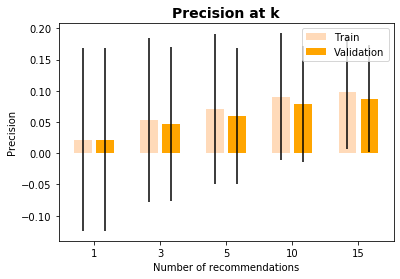

In [35]:
# 5 values for K
x_train = [1, 4, 7, 10, 13]
x_val = [2, 5, 8, 11, 14]


# Training means
y_train = [np.mean(train_df["accuracy_at_1"]),
         np.mean(train_df["accuracy_at_3"]),
         np.mean(train_df["accuracy_at_5"]),
         np.mean(train_df["accuracy_at_10"]),
         np.mean(train_df["accuracy_at_15"])]

# Training stds
error_train = [np.std(train_df["accuracy_at_1"]),
             np.std(train_df["accuracy_at_3"]),
             np.std(train_df["accuracy_at_5"]),
             np.std(train_df["accuracy_at_10"]),
             np.std(train_df["accuracy_at_15"])]

# Validation means
y_val = [np.mean(validation_df["accuracy_at_1"]),
         np.mean(validation_df["accuracy_at_3"]),
         np.mean(validation_df["accuracy_at_5"]),
         np.mean(validation_df["accuracy_at_10"]),
         np.mean(validation_df["accuracy_at_15"])]

# Validation stds
error_val = [np.std(validation_df["accuracy_at_1"]),
             np.std(validation_df["accuracy_at_3"]),
             np.std(validation_df["accuracy_at_5"]),
             np.std(validation_df["accuracy_at_10"]),
             np.std(validation_df["accuracy_at_15"])]

# Plot errorbars
plt.bar(x = x_train, height = y_train, yerr = error_train, color = "peachpuff", label = "Train")
plt.bar(x = x_val, height = y_val, yerr = error_val, color = "orange", label = "Validation")

# Titles and axis labels
plt.title("Precision at k", fontweight = "bold", fontsize = 14)
plt.xlabel("Number of recommendations")
plt.ylabel("Precision")
plt.xticks(ticks = [1.5, 4.5, 7.5, 10.5, 13.5], labels = [1, 3, 5, 10, 15])

# Add legend
plt.legend()

# Show plot
plt.show()

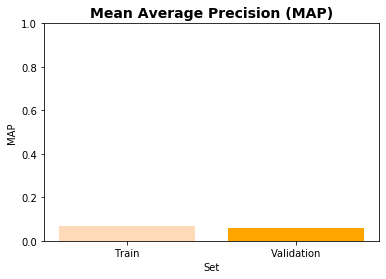

In [36]:
# Plot MAP
plt.bar(x = 1, height = MAP_train, color = "peachpuff", label = "Train")
plt.bar(x = 2, height = MAP_validation, color = "orange", label = "Validation")

# Titles and axis labels
plt.title("Mean Average Precision (MAP)", fontweight = "bold", fontsize = 14)
plt.xlabel("Set")
plt.ylabel("MAP")
plt.ylim((0, 1))
plt.xticks(ticks = [1, 2], labels = ["Train", "Validation"])

# Show plot
plt.show()

# User based (correlation)

In [11]:
user_ratings = pd.DataFrame(df.groupby('reviewerID')['overall'].mean())
user_ratings.head()

,overall
reviewerID,
A0059486XI1Z0P98KP35,5.000000
A0220159ZRNBTRKLG08H,4.600000
A0266076X6KPZ6CCHGVS,5.000000
A0277912HT4JSJKVSL3E,4.500000
A02836981FYG9912C66F,3.714286


In [13]:
user_ratings['number_of_reviews'] = df.groupby('reviewerID')['overall'].count()
user_ratings.head()

,overall,number_of_reviews
reviewerID,,
A0059486XI1Z0P98KP35,5.000000,4
A0220159ZRNBTRKLG08H,4.600000,5
A0266076X6KPZ6CCHGVS,5.000000,14
A0277912HT4JSJKVSL3E,4.500000,10
A02836981FYG9912C66F,3.714286,7


In [51]:
game_matrix

productID,0700026398,0700026657,0700099867,0804161380,3828770193,6050036071,7293000936,7544256944,8176503290,8565000168,...,B01HD1B76O,B01HD2TECW,B01HDJFJKG,B01HDJFJLK,B01HDJFJOM,B01HFRICLE,B01HGPUTCA,B01HH6JEOC,B01HIZF7XE,B01HIZGKOE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0059486XI1Z0P98KP35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0220159ZRNBTRKLG08H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0266076X6KPZ6CCHGVS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0277912HT4JSJKVSL3E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A02836981FYG9912C66F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZNK89PXD006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZQCK9ZAKMFR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZT1ERHBSNQ8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
test=game_matrix.loc["AZZTOUKVTUMVM",:]

In [64]:
sum(test.isnull())

17403

In [44]:
similar_to=game_matrix.corrwith(test,axis = 0)

In [45]:
similar_to

productID
0700026398   NaN
0700026657   NaN
0700099867   NaN
0804161380   NaN
3828770193   NaN
              ..
B01HFRICLE   NaN
B01HGPUTCA   NaN
B01HH6JEOC   NaN
B01HIZF7XE   NaN
B01HIZGKOE   NaN
Length: 17408, dtype: float64

In [46]:
corr = pd.DataFrame(similar_to, columns=['Correlation'])

In [47]:
corr.dropna(inplace=True)

In [15]:
def user_based_CF(user_id, number_of_reviews):
    user_rating=game_matrix.loc[user_id,:]
    similar_to=game_matrix.corrwith(user_rating,axis = 0)
    corr = pd.DataFrame(similar_to, columns=['Correlation'])
    corr.dropna(inplace=True)
    corr = corr.join(user_ratings['number_of_reviews'])
    corr_sorted=corr[corr['number_of_reviews'] > number_of_reviews].sort_values(by='Correlation', ascending=False)
    #i=0
    #idx=0
    #result=""
    #while i<10:
        #if corr_sorted.index[idx]!=productID:
            #result=result+corr_sorted.index[idx]+","
            #i=i+1  
        #idx=idx+1
    return corr_sorted

In [16]:
user_based_CF("A0059486XI1Z0P98KP35",3)

,Correlation,number_of_reviews
productID,,


### Item based model output

In [97]:
product_list=df.productID.value_counts().index

In [98]:
col_name = ["ProductID", "Recommended Products"]
item_based_recommendation=pd.DataFrame(columns=col_name)

In [100]:
from tqdm import tqdm
for product_ID in tqdm(product_list):
    result=user_based_CF(product_ID, 30)
    item_based_recommendation.loc[len(item_based_recommendation)]=[product_ID, result]

  0%|          | 59/17408 [1:05:53<322:53:10, 67.00s/it]

KeyboardInterrupt



In [111]:
item_based_recommendation

,ProductID,Recommended Products
0,B00JK00S0S,"B00SXEOO1Q,B00DFT92EI,B0025KZV7A,B006ZTHFPS,B0..."
1,B003ZSP0WW,"B0060QTIZG,B00KDJJL8A,B00VU4J13W,B00FXOP1JI,B0..."
2,B00178630A,"B00JUFT1E2,B00CLW3TZS,B00E8A06DO,B000LFJNF2,B0..."
3,B00JK00S0S,"B00SXEOO1Q,B00DFT92EI,B0025KZV7A,B006ZTHFPS,B0..."
4,B003ZSP0WW,"B0060QTIZG,B00KDJJL8A,B00VU4J13W,B00FXOP1JI,B0..."
...,...,...
57,B00WTI3JPE,"B00SXEOOHU,B001ASJIS6,B0051BH6FK,B00EFRN2IQ,B0..."
58,B00L59D9HG,"B00Y0CIZW4,B006476318,B00004SQPD,B01A9UATJC,B0..."
59,B000ZKA0J6,"B004APAEHA,B000HKGD4A,B0009IX7K8,B00KAED6Y8,B0..."
60,B002I0H79C,"B01GW3POY0,B0050SYPV2,B00KAEIS6O,B00KAED6RU,B0..."


In [114]:
product_list[product_list==]

Index(['B00CMQTVUA'], dtype='object')

In [119]:
product_list[3]

'B00GODZYNA'

In [53]:
#Test
user_based_CF("B00001OWYW", 100)

'B00000DMB3,B00004SVV9,B0009VXBAQ,B000UW21A0,B000XJNTNS,B001HWB68K,B00009WNZA,B001TOQ8UW,B003ZHMMEM,B009EWHKAI,'

## User based (Surprise Package)

In [10]:
# recommender.py
from surprise import KNNWithMeans
from surprise.prediction_algorithms import BaselineOnly
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise import SVD, accuracy,SVDpp,SlopeOne,NormalPredictor,KNNBaseline,KNNBasic,KNNWithZScore,CoClustering
from collections import defaultdict 
from surprise.model_selection import KFold

from surprise import Dataset

#### Load the data

In [3]:
with open('train_df.pkl', 'rb') as f:
    train = pickle.load(f)

In [4]:
with open('test_df.pkl', 'rb') as f:
    test = pickle.load(f)

In [6]:
train.shape

(206085, 20)

In [7]:
test.shape

(84554, 20)

#### Let us compare different algorithms

In [5]:
#The column order has to be user id, product id, and ratings
reader = Reader(rating_scale=(0, 5))
dat = Dataset.load_from_df(df[['reviewerID', 'productID', 'overall']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [NormalPredictor(), KNNBaseline(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, dat, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


### KNNWithMeans 

In [8]:
train.head(2)

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,category,title,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews
473590,473590,5,False,2016-07-16,A2KJVIU82ZUSBA,B0186D1UQ0,Fantastic,Best Remake I've Ever Played,0,{'Format:': ' Video Game'},"['Video Games', 'PlayStation 4', 'Games', '']",Odin Sphere Leifthrasir - PlayStation 4 Standa...,by Atlus,">#4,665 in Video Games (See Top 100 in Video G...",Video Games,"[""ATLUS x Vanillaware, the team behind the hit...","['B077Y7313L', 'B0794Y8FLW', 'B01HQGWBZ2', 'B0...","['B077Y7313L', 'B0794Y8FLW', 'B017GY06UQ', 'B0...","['HD Art Upgrade: Known for its beautiful, 2D ...",26
128446,128446,5,True,2014-07-18,A3GENOZU8QJZAZ,B000R39GPA,Great game,PS3,0,"{'Edition:': ' Standard', 'Platform:': ' PlayS...","['Video Games', 'PlayStation 3', 'Games', '']",Star Wars: The Force Unleashed,by LucasArts,">#9,056 in Video Games (See Top 100 in Video G...",Video Games,['The Star Wars saga will continue in Star War...,"['B0030F1DOO', 'B003FMUMBM', 'B00EY3F8LU', 'B0...","['B01BCMBP44', 'B0030F1DOO', 'B00EY3F8LU', 'B0...",['Confront and associate with familiar faces f...,140


In [8]:
reader = Reader(rating_scale=(0, 5))
train_dat = Dataset.load_from_df(train[['reviewerID', 'productID', 'overall']], reader)
train_dat=train_dat.build_full_trainset()

In [33]:
reader = Reader(rating_scale=(0, 5))
test_dat = Dataset.load_from_df(test[['reviewerID', 'productID', 'overall']], reader)
test_dat=test_dat.build_full_trainset().build_testset()

In [12]:
sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

In [13]:
algo.fit(test_dat)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [34]:
predictions = algo.test(test_dat)

In [35]:
accuracy.rmse(predictions)

RMSE: 1.1580


1.1580233668034547

In [36]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

In [37]:
#Averaging precision and recalls over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8997849641761455
0.7604591940229316


### SVD

In [23]:
#splitting dataset into train and test set in a ratio of 75%:25%
trainset, testset = train_test_split(dat, test_size=0.25)

In [126]:
#SVD is a Matrix Factorization techniques are usually more effective because 
#they allow us to discover the latent features underlying the interactions between users and items.

#This is to predict each user's ratings for each item
algo = SVD()
algo.fit(trainset)

In [127]:
predictions = algo.test(testset)

RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction.

In [128]:
accuracy.rmse(predictions)

RMSE: 1.0512


1.0512387445750877

In [134]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [135]:
top_n = get_top_n(predictions, n=10)

In [136]:
top_n

defaultdict(list,
            {'A18PV2UTTCCKCA': [('B00L3LQ1FI', 4.741907641059698),
              ('B0016C3260', 4.723147721276671),
              ('B00OGPTED4', 4.41907996674117),
              ('B009EWHKAI', 4.084348381955695)],
             'A2HPAI1FOYRPVM': [('B014N4RTS4', 4.299125896505516)],
             'A722OKUN3SFK2': [('B00ENFVJJO', 4.353552341164688),
              ('B004MKN3Y4', 4.08656025221981)],
             'A3UEQ1CYG8E6D2': [('B00ENFVJJO', 4.257045630926968),
              ('B00ECOAX9I', 4.130142216180508),
              ('B00KLMOY4K', 3.9582715608239463),
              ('B00KLMOY54', 3.944730984380021)],
             'AXOLU7ZN30KEP': [('B0094HB3G0', 4.268971633339539),
              ('B009IF0EUE', 3.98271916996993)],
             'A2KSB6DA0TMUB8': [('B000MUW98O', 4.475933775738622),
              ('B0025KZV7A', 4.356624784062517)],
             'A199968JC2ELJD': [('B001E8VB3C', 4.7135540779907155),
              ('B00439DIZ8', 4.284450650365469),
              ('B005

In [26]:
def precision_recall_at_k(predictions, k=10, threshold=0.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [139]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

In [140]:
precisions

{'A18PV2UTTCCKCA': 0.75,
 'A2HPAI1FOYRPVM': 1.0,
 'A722OKUN3SFK2': 1.0,
 'A3UEQ1CYG8E6D2': 1.0,
 'AXOLU7ZN30KEP': 1.0,
 'A2KSB6DA0TMUB8': 1.0,
 'A199968JC2ELJD': 1.0,
 'A3M3QP00DJ4SMI': 1.0,
 'A2SJA970FO024V': 1,
 'A2MULN6J3153MS': 0.5,
 'A3M80FX19LMDVP': 1.0,
 'A2NUHWMHA9XNKV': 1.0,
 'AFNG8O2DXRCUV': 1.0,
 'A2WS409CFVVKDS': 1.0,
 'AH0Y1UPFAD6M5': 1.0,
 'A3DJ5PQLO9FVL4': 1,
 'A3AUBTM5O5ODL0': 1.0,
 'A1S12A8FLNA0XD': 1.0,
 'AHRUH43GZIUQM': 1.0,
 'A1G2V8ROLBIS43': 0.5,
 'A1ML0GUB02JMQ4': 0.5,
 'A27A2OSB01YOBB': 1.0,
 'A119Q9NFGVOEJZ': 1.0,
 'A1D2ZN57YG2NMH': 0.8,
 'AY1ZBFWXL9JSF': 1.0,
 'A1UPNUCA5ATMPP': 0.0,
 'A215FGX3D3Q4E4': 0.6666666666666666,
 'ANMPFSIJE5N5O': 1.0,
 'A7E0IHHPYOM5I': 0.4,
 'A3BY2QW7T0401N': 1.0,
 'AUAM5OWVN8AJ8': 1.0,
 'A1EOVXHREIJTQZ': 1.0,
 'AJSVGQG8XDVQ3': 1.0,
 'A10I7S85XQVD6N': 0.75,
 'A35K5MWU5RNMXX': 1.0,
 'A16MTWXVFS2LJ8': 1.0,
 'AKOMJ3GZ1RQ6V': 1.0,
 'AIWQ7IO0KUONN': 1.0,
 'A2LDWYW38O4N6H': 0.5,
 'A3M82I6X801R9L': 1.0,
 'A29BQ6B90Y1R5F': 1.0,
 'A1JMDX0TCSS75

In [141]:
recalls

{'A18PV2UTTCCKCA': 1.0,
 'A2HPAI1FOYRPVM': 1.0,
 'A722OKUN3SFK2': 1.0,
 'A3UEQ1CYG8E6D2': 1.0,
 'AXOLU7ZN30KEP': 1.0,
 'A2KSB6DA0TMUB8': 1.0,
 'A199968JC2ELJD': 1.0,
 'A3M3QP00DJ4SMI': 0.5,
 'A2SJA970FO024V': 0.0,
 'A2MULN6J3153MS': 0.3333333333333333,
 'A3M80FX19LMDVP': 0.5,
 'A2NUHWMHA9XNKV': 0.7142857142857143,
 'AFNG8O2DXRCUV': 0.5555555555555556,
 'A2WS409CFVVKDS': 0.8333333333333334,
 'AH0Y1UPFAD6M5': 1.0,
 'A3DJ5PQLO9FVL4': 0.0,
 'A3AUBTM5O5ODL0': 1.0,
 'A1S12A8FLNA0XD': 0.5,
 'AHRUH43GZIUQM': 1.0,
 'A1G2V8ROLBIS43': 0.5,
 'A1ML0GUB02JMQ4': 1.0,
 'A27A2OSB01YOBB': 1.0,
 'A119Q9NFGVOEJZ': 0.056179775280898875,
 'A1D2ZN57YG2NMH': 0.5714285714285714,
 'AY1ZBFWXL9JSF': 1.0,
 'A1UPNUCA5ATMPP': 1,
 'A215FGX3D3Q4E4': 1.0,
 'ANMPFSIJE5N5O': 0.7142857142857143,
 'A7E0IHHPYOM5I': 0.6666666666666666,
 'A3BY2QW7T0401N': 1.0,
 'AUAM5OWVN8AJ8': 0.625,
 'A1EOVXHREIJTQZ': 1.0,
 'AJSVGQG8XDVQ3': 1.0,
 'A10I7S85XQVD6N': 0.75,
 'A35K5MWU5RNMXX': 1.0,
 'A16MTWXVFS2LJ8': 0.8333333333333334,
 'AKOMJ3

In [142]:
#Averaging precision and recalls over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.8841066472086311
0.8072541746226478
